In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# read the brainstroke csv file into R by downloading/uploading it into Google Drive and using a direct output link
brainstroke_data <- read_csv("https://drive.google.com/uc?export=download&id=1yBiO_qBE9_YBvnEyPe2bazH5ZCOBb1d6")

brainstroke_data

Rows: 4981 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, ever_married, work_type, Residence_type, smoking_status
dbl (6): age, hypertension, heart_disease, avg_glucose_level, bmi, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,40,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
Female,45,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Yes,Private,Rural,83.94,30.0,smokes,0
Female,80,1,0,Yes,Private,Urban,83.75,29.1,never smoked,0


<b> GENDER </b> - male (1), female (2)

<b> SMOKING STATUS </b> - never smoked (1), formerly smoked (2), smokes (3), Unknown (4)

<b> WORK TYPE </b> - private (1), self-employed (2), govt job (3)

<b> RESIDENCE TYPE </b> - rural (1), urban (2)

In [4]:
# changing chr data to categorical data (gender, smoking status, work type, residence type, hypertension, heart disease)
# removing ever_married column
# changed Residence_type and bmi column names

brainstroke_data_v1 <- brainstroke_data |>
    mutate(across(c(gender, hypertension:Residence_type, smoking_status:stroke),
                  as_factor)) |>
    select(1:4, 6:11)

colnames(brainstroke_data_v1)[6] <- 'residence_type'
colnames(brainstroke_data_v1)[8] <- 'body_mass_index'

brainstroke_data_v1


# checking possible values for gender, work type, residence type, and smoking status

unique(brainstroke_data_v1$gender)
unique(brainstroke_data_v1$work_type)
unique(brainstroke_data_v1$residence_type)
unique(brainstroke_data_v1$smoking_status)

gender,age,hypertension,heart_disease,work_type,residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,40,0,0,Private,Urban,191.15,31.1,smokes,0
Female,45,1,0,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Private,Rural,83.94,30.0,smokes,0
Female,80,1,0,Private,Urban,83.75,29.1,never smoked,0


[1] Male   Female
Levels: Male Female

[1] Private       Self-employed Govt_job      children     
Levels: Private Self-employed Govt_job children

[1] Urban Rural
Levels: Urban Rural

[1] formerly smoked never smoked    smokes          Unknown        
Levels: formerly smoked never smoked smokes Unknown

<b> FOR FACTOR DATA - </b> yes (1), no (0) (hypertension, heart disease, stroke)

In [5]:
#####
# creating objects for number of observations and number of those with/without stroke
total_obs <- nrow(brainstroke_data_v1)
no_stroke_obs <- nrow(filter(brainstroke_data_v1, stroke == 0))
stroke_obs <- nrow(filter(brainstroke_data_v1, stroke == 1))


#####
# 1. Summarized table 1: check for missing data
not_available <- brainstroke_data_v1 |>
    summarize(across(everything(), ~ sum(is.na(.))))
not_available

# 2. Summarized table 2: stroke counts and proportions
stroke_proportions <- brainstroke_data_v1 |>
    group_by(stroke) |>
    summarize(stroke_count = n(),
              percentage = round((stroke_count / total_obs) * 100, 2))
stroke_proportions

# 3. Summarized table 3: average bmi, glucose level, and age of those with/without stroke
stroke_bmi_gluc_age_avg <- brainstroke_data_v1 |>
    group_by(stroke) |>
    summarise(avg_bmi = round(mean(body_mass_index), 2),
              avg_glucose = round(mean(avg_glucose_level), 2),
              avg_age = round(mean(age), 2))
stroke_bmi_gluc_age_avg

# 4. Summarized table 4: smoking status counts and proportions between those who have/have not gotten a stroke
smoker_proportions_stroke <- brainstroke_data_v1 |>
    group_by(stroke, smoking_status) |>
    summarize(stroke_smoker_count = n(),
              percentage = round((stroke_smoker_count / 
              ifelse(stroke == 0, no_stroke_obs, stroke_obs) * 100), 2)) |>
    distinct()
smoker_proportions_stroke

# 5. Summarized table 5: hypertension counts and proportions between those who have/have not gotten a stroke
hypertension_stroke <- brainstroke_data_v1 |>
    mutate(hypertension = ifelse(hypertension == 0, 'No', 'Yes')) |>
    group_by(stroke, hypertension) |>
    summarize(stroke_hypertension_count = n(),
              percentage = round((stroke_hypertension_count / 
              ifelse(stroke == 0, no_stroke_obs, stroke_obs) * 100), 2)) |>
    distinct()
hypertension_stroke

# 6. Summarized table 6: heart disease counts and proportions between those who have/have not gotten a stroke
heart_disease_stroke <- brainstroke_data_v1 |>
    mutate(heart_disease = ifelse(heart_disease == 0, 'No', 'Yes')) |>
    group_by(stroke, heart_disease) |>
    summarize(stroke_heartdisease_count = n(),
              percentage = round((stroke_heartdisease_count / 
              ifelse(stroke == 0, no_stroke_obs, stroke_obs) * 100), 2)) |>
    distinct()   
heart_disease_stroke

gender,age,hypertension,heart_disease,work_type,residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


stroke,stroke_count,percentage
<fct>,<int>,<dbl>
0,4733,95.02
1,248,4.98


stroke,avg_bmi,avg_glucose,avg_age
<fct>,<dbl>,<dbl>,<dbl>
0,28.41,104.57,42.14
1,30.19,132.18,67.82


`summarise()` has grouped output by 'stroke', 'smoking_status'. You can
override using the `.groups` argument.


stroke,smoking_status,stroke_smoker_count,percentage
<fct>,<fct>,<int>,<dbl>
0,formerly smoked,797,16.84
0,never smoked,1749,36.95
0,smokes,734,15.51
0,Unknown,1453,30.70
1,formerly smoked,70,28.23
1,never smoked,89,35.89
1,smokes,42,16.94
1,Unknown,47,18.95


`summarise()` has grouped output by 'stroke', 'hypertension'. You can override
using the `.groups` argument.


stroke,hypertension,stroke_hypertension_count,percentage
<fct>,<chr>,<int>,<dbl>
0,No,4320,91.27
0,Yes,413,8.73
1,No,182,73.39
1,Yes,66,26.61


`summarise()` has grouped output by 'stroke', 'heart_disease'. You can override
using the `.groups` argument.


stroke,heart_disease,stroke_heartdisease_count,percentage
<fct>,<chr>,<int>,<dbl>
0,No,4505,95.18
0,Yes,228,4.82
1,No,201,81.05
1,Yes,47,18.95


In [6]:
# visualizations

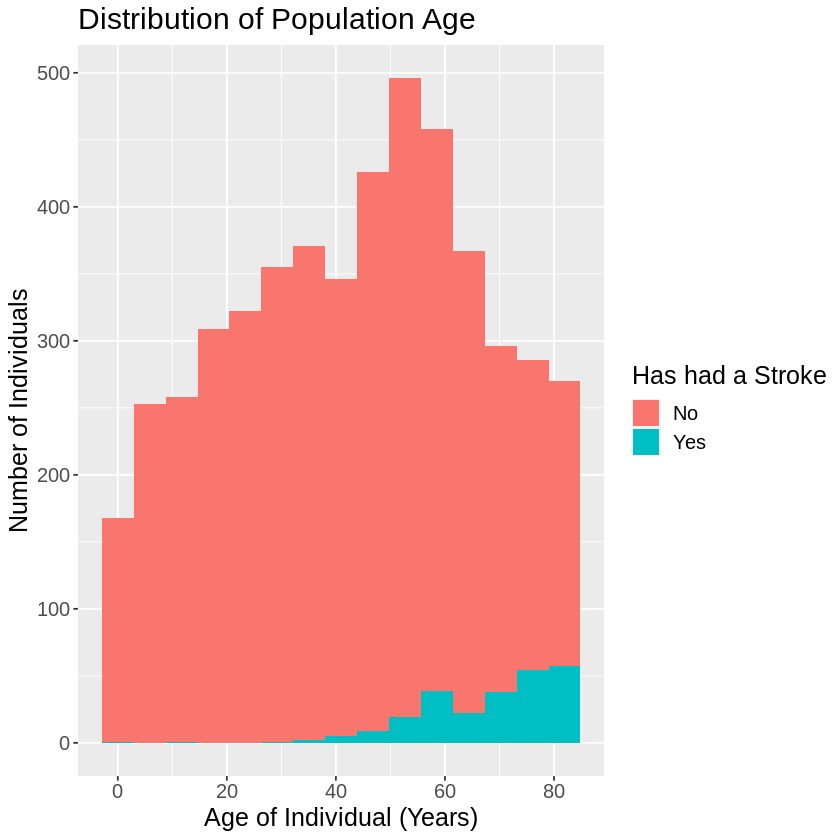

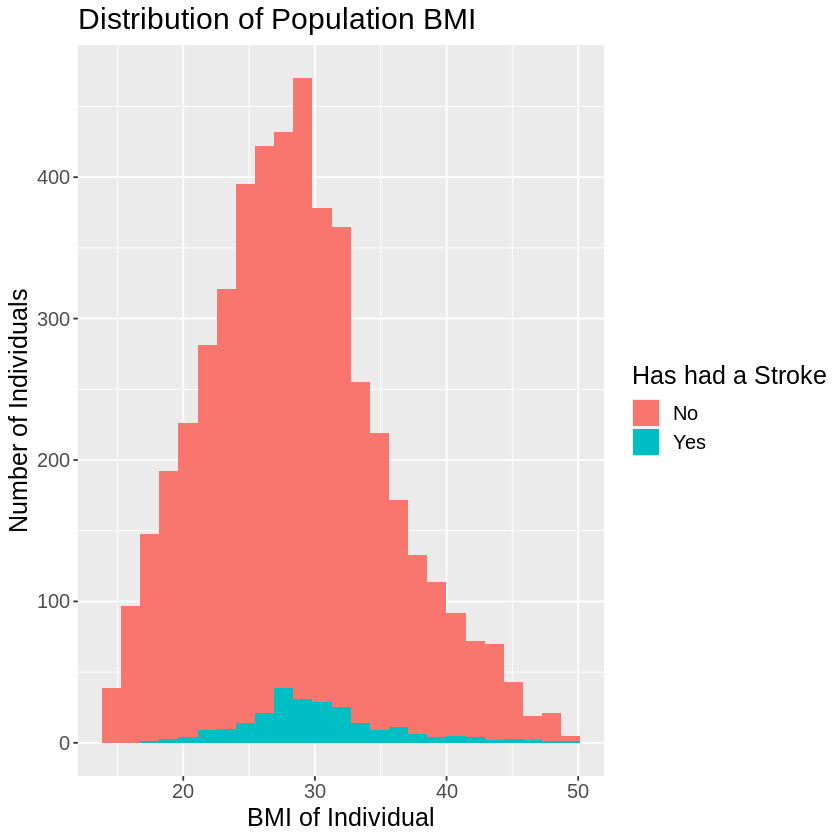

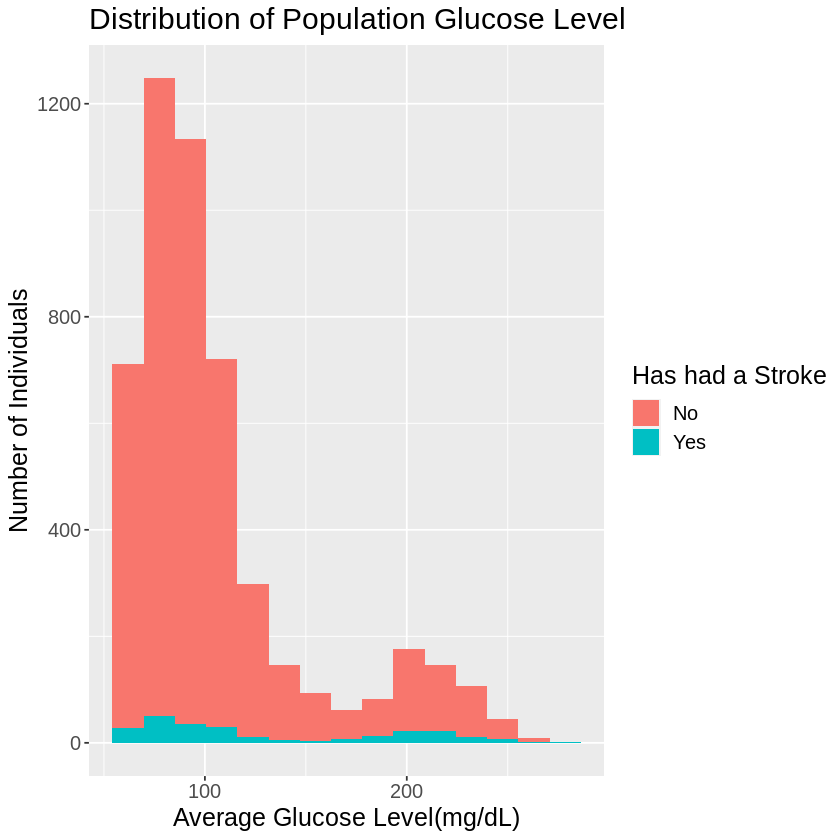

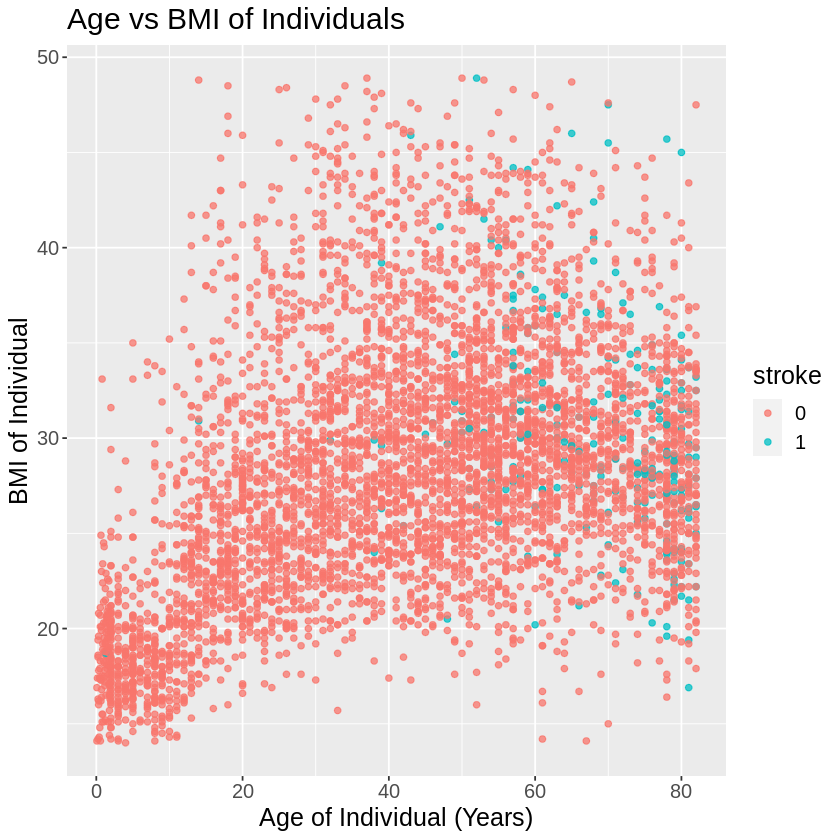

In [12]:
histogram_data <- brainstroke_data_v1 |>
    mutate(stroke = recode(stroke, '0' = "No", '1' = "Yes"))
    

age_histogram_plot <- histogram_data |>
    ggplot(aes(x = age, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Age of Individual (Years)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Age") +
    theme(text = element_text(size=15))

age_histogram_plot

bmi_histogram_plot <- histogram_data |>
    ggplot(aes(x = body_mass_index, fill = stroke)) +
    geom_histogram(bins = 25) +
    xlab("BMI of Individual") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population BMI") +
    theme(text = element_text(size=15))

bmi_histogram_plot

glucose_histogram_plot <- histogram_data |>
    ggplot(aes(x = avg_glucose_level, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Average Glucose Level(mg/dL)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Glucose Level") +
    theme(text = element_text(size=15))

glucose_histogram_plot

age_bmi_scatterplot <- brainstroke_data_v1 |>
    ggplot(aes(x = age, y = body_mass_index, color = stroke)) +
    geom_point(alpha = 0.75) +
    xlab("Age of Individual (Years)") +
    ylab("BMI of Individual") +
    ggtitle("Age vs BMI of Individuals") +
    theme(text = element_text(size=15))

age_bmi_scatterplot

In [8]:
# # changing chr data to categorical int data (gender, smoking status, work type, residence type)
# # changing dbl data to categorical int data (hypertension, heart disease)
# # removing ever_married column
# # changing Residence_type to residence_type

# brainstroke_data_v1 <- brainstroke_data |>
#     mutate(gender = as_factor(ifelse(gender == 'Male', 1, 2)),
#            smoking_status = as_factor(ifelse(smoking_status == 'never smoked', 1, 
#                                       ifelse(smoking_status == 'formerly smoked', 2, 
#                                       ifelse(smoking_status == 'smokes', 3, 
#                                       ifelse(smoking_status == 'Unknown', 4, 'n/a'))))),
#            work_type = as_factor(ifelse(work_type == 'Private', 1, 
#                        ifelse(work_type == 'Self-employed', 2, 
#                        ifelse(work_type == 'Govt_job', 3, 'n/a')))),
#            Residence_type = as_factor(ifelse(Residence_type == 'Rural', 1, 2)),
#            stroke = as_factor(stroke),
#            heart_disease = as_factor(heart_disease),
#            hypertension = as_factor(hypertension)) |>
#     select(1:4, 6:11) 

# colnames(brainstroke_data_v1)[6] <- 'residence_type'

# brainstroke_data_v1

In [9]:
# # changing chr data to categorical int data (gender, smoking status, work type, residence type)
# # changing dbl data to categorical int data (hypertension, heart disease)
# # removing ever_married column
# # changing Residence_type to residence_type

# brainstroke_data_v1 <- brainstroke_data |>
#     mutate(gender = as_factor(ifelse(gender == 'Male', 1, 2)),
#            smoking_status = as_factor(ifelse(smoking_status == 'never smoked', 1, 
#                                       ifelse(smoking_status == 'formerly smoked', 2, 
#                                       ifelse(smoking_status == 'smokes', 3, 
#                                       ifelse(smoking_status == 'Unknown', 4, 'n/a'))))),
#            work_type = as_factor(ifelse(work_type == 'Private', 1, 
#                        ifelse(work_type == 'Self-employed', 2, 
#                        ifelse(work_type == 'Govt_job', 3, 'n/a')))),
#            Residence_type = as_factor(ifelse(Residence_type == 'Rural', 1, 2)),
#            stroke = as_factor(stroke),
#            heart_disease = as_factor(heart_disease),
#            hypertension = as_factor(hypertension)) |>
#     select(1:4, 6:11) 

# colnames(brainstroke_data_v1)[6] <- 'residence_type'

# brainstroke_data_v1

# brainstroke_data_v1 <- brainstroke_data |>
#     mutate(gender = as_factor(gender),
#            smoking_status = as_factor(smoking_status),
#            work_type = as_factor(work_type),
#            Residence_type = as_factor(Residence_type),
#            stroke = as_factor(stroke),
#            heart_disease = as_factor(heart_disease),
#            hypertension = as_factor(hypertension)) |>
#     select(1:4, 6:11) 

# colnames(brainstroke_data_v1)[6] <- 'residence_type'
# colnames(brainstroke_data_v1)[8] <- 'body_mass_index'

# brainstroke_data_v1

# # 6. summarized table 5: mean average glucose levels of those with/without stroke
# stroke_glucose <- brainstroke_data_v1 |>
#     group_by(stroke) |>
#     summarise(mean_glucose = mean(avg_glucose_level))
# stroke_glucose
# # 7. summarized table 6: mean age of those with/without stroke
# stroke_age <- brainstroke_data_v1 |>
#     group_by(stroke) |>
#     summarise(avg_age = mean(age))
# stroke_age
# # getting total number of observations and number of observations for male and female
# total_obs <- nrow(brainstroke_data_v1)
# male_obs <- nrow(filter(brainstroke_data_v1, gender == 'Male'))
# female_obs <- nrow(filter(brainstroke_data_v1, gender == 'Female'))

# Summarized table: smoker proportions among those with stroke
# stroke_obs <- nrow(filter(brainstroke_data_v1, stroke == 1))

# stroke_smokers <- brainstroke_data_v1 |>
#     filter(stroke == 1) |>
#     group_by(smoking_status) |>
#     summarize(smoker_count = n(),
#               percentage = (smoker_count / stroke_obs) * 100) 
    
# stroke_smokers
# 3. Summarized table 3: gender, age, and stroke of top 8 highest glucose level
# top_7_avg_glucose <- brainstroke_data_v1 |>
#     select(gender, age, avg_glucose_level, stroke) |>
#     arrange(desc(avg_glucose_level)) |>
#     head(7)

# top_7_avg_glucose

# 3. Summarized table 3: gender counts and proportions between those who have/have not gotten a stroke
# gender_proportions_by_stroke <- brainstroke_data_v1 |>
#     group_by(stroke, gender) |>
#     summarize(stroke_gender_count = n(),
#               percentage = round((stroke_gender_count / 
#               ifelse(stroke == 0, no_stroke_obs, stroke_obs) * 100), 2)) |>
#     distinct()

# gender_proportions_by_stroke